In [1]:
# The librairie py2neo is used as driver to connect python to a Neo4j database
!pip install py2neo

In [3]:
# import librairies
import numpy as np 
import pandas as pd
from py2neo import Graph
import matplotlib.pyplot as plt
import time

Load the netflix data

In [16]:
# load the data
df = pd.read_csv(r'Data\netflix_titles.csv')

df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [21]:
df['date_added'] = df['date_added'].str.strip()
df["date_added"] = pd.to_datetime(df['date_added'])
df['year'] = df['date_added'].dt.year
df['month'] = df['date_added'].dt.month
df['day'] = df['date_added'].dt.day

df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year,month,day
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019-09-09,2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,2019.0,9.0,9.0
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016-09-09,2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,2016.0,9.0,9.0
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,2018-09-08,2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob...",2018.0,9.0,8.0
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,2018-09-08,2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,2018.0,9.0,8.0
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017-09-08,2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...,2017.0,9.0,8.0


In [59]:
#Connect to neo4j sandbox
ip="localhost"
port="7687"
pwd="connect-to-dbms"
graph = Graph("bolt://"+ip+":"+port, auth=("neo4j", pwd))

In [61]:
try:
    version = graph.run("CALL dbms.components() YIELD name, versions RETURN versions").data()
    print("✅ Connected! Version Neo4j:", version[0]['versions'])
except Exception as e:
    print("❌  Not Connected :", e)

✅ Connected! Version Neo4j: ['5.26.1']


### Load the data from the dataframe to neo4j graph DB
<h6>------Remark : execution time can be long, about 6 minutes for requests as "create movies" or "create persons"</h6>

<h6>------So execute it, only once put LOAD_DATA = false, to not load data again</h6>

I have tried the idea to not send a lot of queries through the net :

<h6>-    the first request load all the data as properties of the nodes Movies.</h6>
<h6>-    the other requests build the other nodes with these properties</h6>
<h6>-    at the end, the final request delete the unused properties</h6>

In [78]:
LOAD_DATA = True

def run_request(request,LOAD_DATA=False):
    if (LOAD_DATA):
        start_time = time.time()
        print(graph.run(request)) 
        exec_time = time.time() - start_time
        print(f'-- {exec_time} seconds --')

In [79]:
# DELETE ALL NODES AND RELATIONSHIPS
request_delete ="""
MATCH (n) DETACH DELETE n;
"""
run_request(request_delete,LOAD_DATA)

(No data)
-- 0.11748385429382324 seconds --


In [81]:
# CREATE MOVIES

request ="""
CREATE (m:Movie {id: $show_id, title: $title})
SET 
    m.director = $director,
    m.country = $country,
    m.date_str = $date_added, 
    m.release_year = $release_year,
    m.rating = $rating,
    m.duration = $duration,
    m.listed_in = $listed_in,
    m.description = $description,
    m.cast = $cast,
    m.year = $year,
    m.month = $month,
    m.day = $day,
    m.type = $type_movie
"""

start_time = time.time()
count=df.shape[0]
if (LOAD_DATA):
    for index, row in df.iterrows():
        graph.run(request,
                  show_id=row['show_id'],
                  title=row['title'],
                  director=None if pd.isnull(row['director']) else row['director'],
                  country=None if pd.isnull(row['country']) else row['country'],
                  date_added= None if pd.isnull(row['date_added']) else row['date_added'].strftime('%Y-%m-%d'),
                  release_year=None if pd.isnull(row['release_year']) else row['release_year'],
                  rating=None if pd.isnull(row['rating']) else row['rating'],          
                  duration=None if pd.isnull(row['duration']) else row['duration'],
                  listed_in=None if pd.isnull(row['listed_in']) else row['listed_in'],
                  description=None if pd.isnull(row['description']) else row['description'],
                  cast= None if pd.isnull(row['cast']) else row['cast'],
                  year=None if pd.isnull(row['year']) else row['year'],
                  month=None if pd.isnull(row['month']) else row['month'],
                  day=None if pd.isnull(row['day']) else row['day'],
                  type_movie=None if pd.isnull(row['type']) else row['type']
                  )
        if (index%500==0):
            exec_time = time.time() - start_time
            print(f'{index}/{df.shape[0]} done ... -- {exec_time} seconds --')
        
    exec_time = time.time() - start_time
    print(f' ... End ... -- {exec_time} seconds --')       

0/6234 done ... -- 0.1799907684326172 seconds --
500/6234 done ... -- 3.538106918334961 seconds --
1000/6234 done ... -- 5.2765772342681885 seconds --
1500/6234 done ... -- 6.8137593269348145 seconds --
2000/6234 done ... -- 8.319662094116211 seconds --
2500/6234 done ... -- 9.549163579940796 seconds --
3000/6234 done ... -- 10.821183443069458 seconds --
3500/6234 done ... -- 12.011338710784912 seconds --
4000/6234 done ... -- 12.91935920715332 seconds --
4500/6234 done ... -- 13.988619327545166 seconds --
5000/6234 done ... -- 15.0489661693573 seconds --
5500/6234 done ... -- 16.069895029067993 seconds --
6000/6234 done ... -- 16.87039279937744 seconds --
 ... End ... -- 17.387781143188477 seconds --


In [82]:
# CREATE  PERSONS
request ="""
MATCH (m:Movie)
WHERE m.cast IS NOT NULL
WITH m
UNWIND split(m.cast, ',') AS actor
MERGE (p:Person {name: trim(actor)})
MERGE (p)-[r:ACTED_IN]->(m);
"""    
run_request(request,LOAD_DATA)   

(No data)
-- 162.29196977615356 seconds --


In [83]:
# CREATE CATEGORIES    
request ="""    
MATCH (m:Movie)
WHERE m.listed_in IS NOT NULL
WITH m
UNWIND split(m.listed_in, ',') AS category
MERGE (c:Category {name: trim(category)})
MERGE (m)-[r:IN_CATEGORY]->(c);
"""    
run_request(request,LOAD_DATA)

(No data)
-- 0.572152853012085 seconds --


In [84]:
# CREATE TYPE
request =""" 
MATCH (m:Movie)
WHERE m.type IS NOT NULL
WITH m
MERGE (t:Type {type: m.type})
MERGE (m)-[r:TYPED_AS]->(t);
"""
run_request(request,LOAD_DATA) 

(No data)
-- 0.21728181838989258 seconds --


In [85]:
# CREATE DIRECTOR
request =""" 
MATCH (m:Movie)
WHERE m.director IS NOT NULL
WITH m
MERGE (d:Person {name: m.director})
MERGE (d)-[r:DIRECTED]->(m);
"""
run_request(request,LOAD_DATA) 

(No data)
-- 33.55557131767273 seconds --


In [86]:
# CREATE COUNTRIES
request =""" 
MATCH (m:Movie)
WHERE m.country IS NOT NULL
MERGE (c:Country {name: trim(m.country)})
MERGE (m)-[:WHERE]->(c);
"""
run_request(request,LOAD_DATA)

(No data)
-- 0.545020341873169 seconds --


In [87]:
# DELETE UNUSED PROPERTY
request="""
MATCH(m:Movie)
SET m.country = null, m.category = null,m.type = null , m.director = null , m.cast =null
"""
run_request(request,LOAD_DATA) 

(No data)
-- 0.20209932327270508 seconds --


In [88]:
# BUILD THE WORK_WITH RELATIONSHIP
request = """
MATCH (p:Person)-[rel:ACTED_IN]->(m:Movie)<-[:ACTED_IN]-(p2:Person)
MERGE (p)-[r:WORK_WITH]-(p2);
"""
run_request(request,LOAD_DATA) 

(No data)
-- 2.017343759536743 seconds --


In [91]:
# Create Time Tree Index
request="""
CREATE INDEX year_index FOR (y:Year) ON (y.value);
"""
run_request(request,LOAD_DATA)

(No data)
-- 0.05971169471740723 seconds --


In [92]:
# Create Years
request="""
WITH range(2012, 2019) AS years, range(1,12) AS months
FOREACH(year IN years |
  CREATE (y:Year {value: year}));
"""
run_request(request,LOAD_DATA)

(No data)
-- 0.05363059043884277 seconds --


In [93]:
# Connect Years Sequentially
request="""
MATCH (year:Year)
WITH year
ORDER BY year.value
WITH collect(year) AS years
FOREACH(i in RANGE(0, size(years)-2) |
    FOREACH(year1 in [years[i]] |
        FOREACH(year2 in [years[i+1]] |
            MERGE (year1)-[:NEXT]->(year2))));
"""
run_request(request,LOAD_DATA)

(No data)
-- 0.17946958541870117 seconds --


In [94]:
request="""
MATCH (m:Movie)
WITH m, m.year AS y
MATCH (year:Year {value: y})
MERGE (m)-[:CREATED_ON]->(year)
RETURN m,year;
"""
run_request(request,LOAD_DATA)

 m                                                                                                                                                                                                                                                                                                                                                                                                              | year                          
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------
 (_0:Movie {date_str: '2019-09-09', day: 9.0, description: 'Before planning an awesome wedding for his grandfather, a polar bear king 

Graph cardinalities

TypeError: plot() got an unexpected keyword argument 'x'

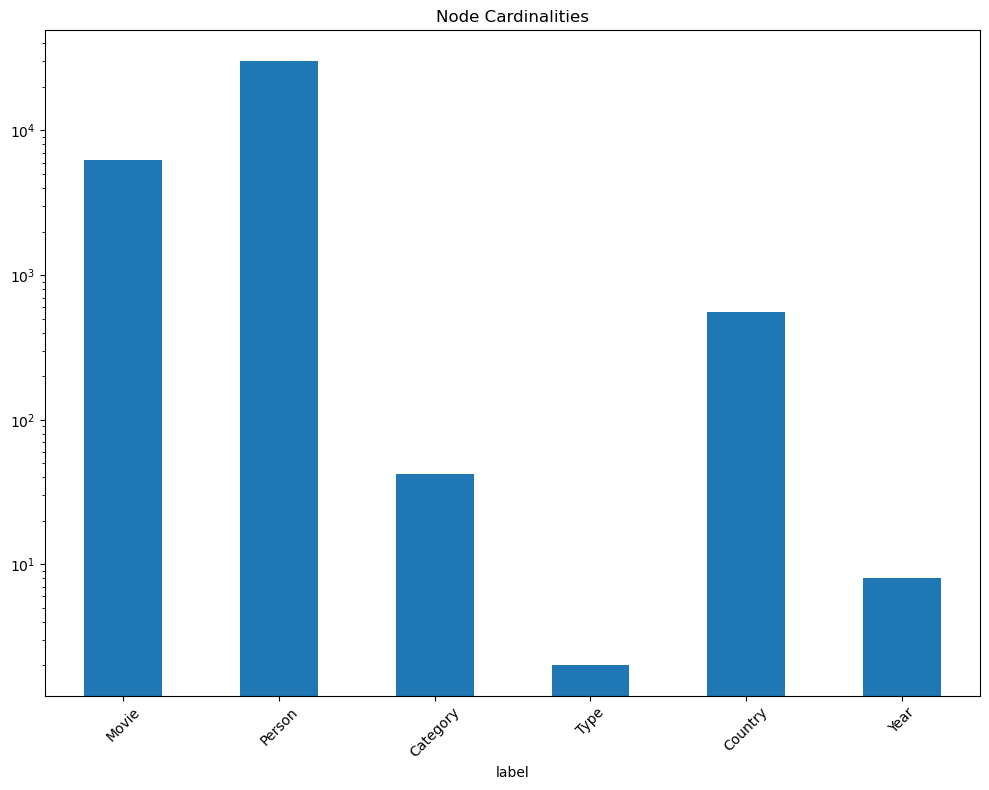

In [95]:
# Nodes Cardinalities
result = {"label": [], "count": []}
for label in graph.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities",figsize=(10,8))
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.plot(kind='bar', x=nodes_df['label'], y=nodes_df['count'], legend=None, title="Node Cardinalities")
plt.show()

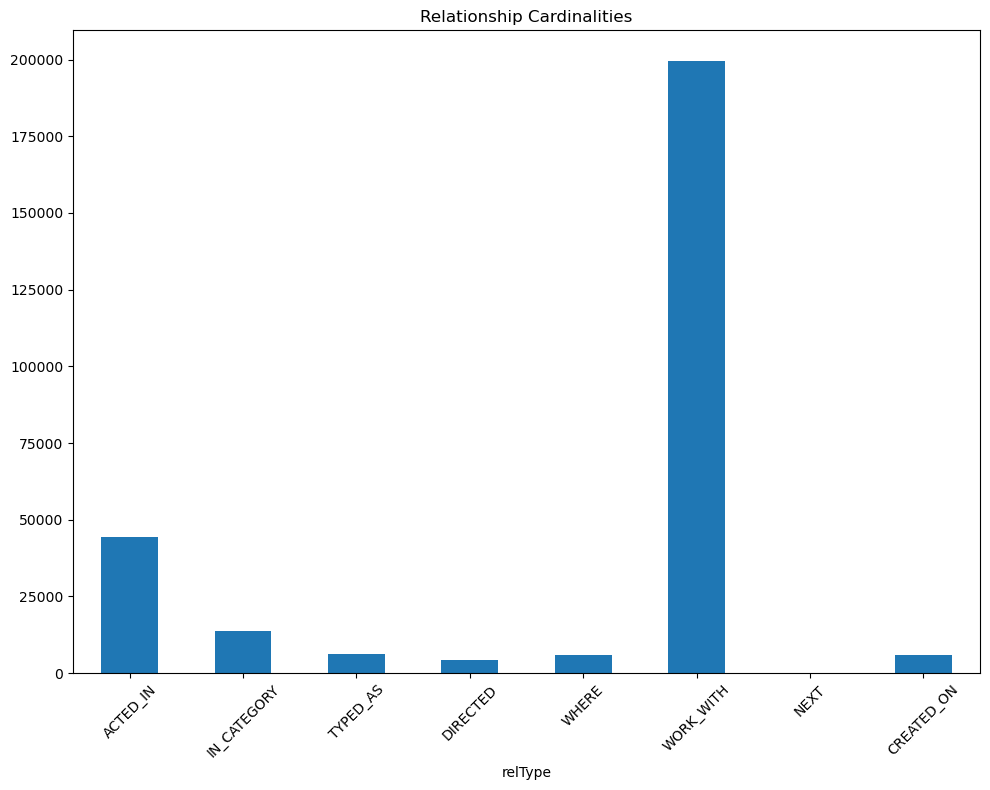

In [96]:
# Relations Ship Cardinalities
result = {"relType": [], "count": []}
for relationship_type in graph.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["relType"].append(relationship_type)
    result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

rels_df.plot(kind='bar', x='relType', y='count', legend=None, title="Relationship Cardinalities",figsize=(10,8))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

TOP 5 ACTOR - Greatest Number of films played

In [97]:
request_top_5_actor="""
MATCH (p:Person)-[rel:ACTED_IN]->(m:Movie)
WITH p,collect(m.title) as movies,count(*) as total
RETURN  p.name, movies,total
ORDER BY total DESC
LIMIT 5
"""
graph.run(request_top_5_actor).to_data_frame().head()

,p.name,movies,total
0,Anupam Kher,"[Wake Up Sid, A Wednesday, Zokkomon, C Kkompan...",33
1,Shah Rukh Khan,[My Next Guest with David Letterman and Shah R...,30
2,Naseeruddin Shah,"[Hope Aur Hum, Main, Meri Patni Aur Woh, SunGa...",27
3,Om Puri,"[Delhi 6, Kismat Konnection, Kurbaan, Chaar Sa...",27
4,Yuki Kaji,"[DRAGON PILOT: Hisone & Masotan, Berserk: The ...",26


#### Count by Category
The grand total does not equal the number of movies, because a movie can be in several categories

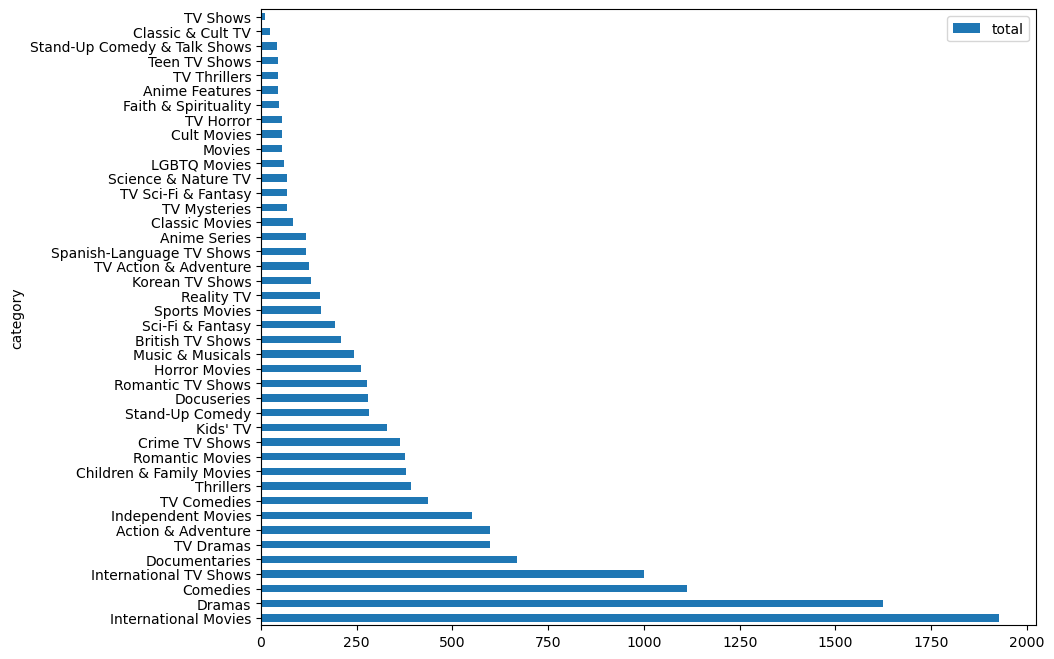

In [98]:
request="""
MATCH (c:Category)<-[rel:IN_CATEGORY]-(m:Movie)
WITH c.name as category,count(*) as total
RETURN  category,total
ORDER BY total DESC
"""
result = graph.run(request).to_data_frame()
result.plot.barh(x='category', y='total',figsize=(10,8))
plt.show()

#### Shortest between 2 persons
If I want to meet someone, who should I ask to be present?

In [107]:
def who_be_present(I_AM, I_WANT_TO_MEET):
    print(f"I'm {I_AM}")
    print(f"I want to meet {I_WANT_TO_MEET}")
    
    request = """
    MATCH (cs:Person { name: $pfrom }), (ms:Person { name: $pto }), 
          p = shortestPath((cs)-[:ACTED_IN|DIRECTED*]-(ms)) 
    WHERE length(p) > 1 
    RETURN p
    """
    
    cursor = graph.run(request, pfrom=I_AM, pto=I_WANT_TO_MEET)

    for record in cursor:
        print(record["p"])
    print("\n")

In [108]:
I_AM='Brad Anderson'
I_WANT_TO_MEET='Brad Pitt'
who_be_present(I_AM,I_WANT_TO_MEET)

I_AM='Kanwaljeet Singh'
I_WANT_TO_MEET='Nick Nolte'
who_be_present(I_AM,I_WANT_TO_MEET)

I'm Brad Anderson
I want to meet Brad Pitt
(Brad Anderson)-[:DIRECTED {}]->(_23)<-[:ACTED_IN {}]-(Brendan Gleeson)-[:ACTED_IN {}]->(_3932)<-[:ACTED_IN {}]-(Daniel Brühl)-[:ACTED_IN {}]->(_2883)<-[:ACTED_IN {}]-(Brad Pitt)


I'm Kanwaljeet Singh
I want to meet Nick Nolte
(Kanwaljeet Singh)-[:ACTED_IN {}]->(_3206)<-[:ACTED_IN {}]-(Akshay Kumar)-[:ACTED_IN {}]->(_125)<-[:ACTED_IN {}]-(Aml Ameen)-[:ACTED_IN {}]->(_6087)<-[:ACTED_IN {}]-(Joe Pantoliano)-[:ACTED_IN {}]->(_4011)<-[:ACTED_IN {}]-(Nick Nolte)




Evolution over year - Number of movies by countries

In [109]:
request="""
MATCH (y:Year {value: 2012})-[:NEXT*0..10]->(y2:Year)<-[:CREATED_ON]-(f:Movie)-[r:WHERE]->(c:Country)
RETURN y2.value as year,c.name as country,count(r) as count
ORDER BY year DESC, count DESC
"""
result = graph.run(request).to_data_frame()
filter=result['country'][:10]

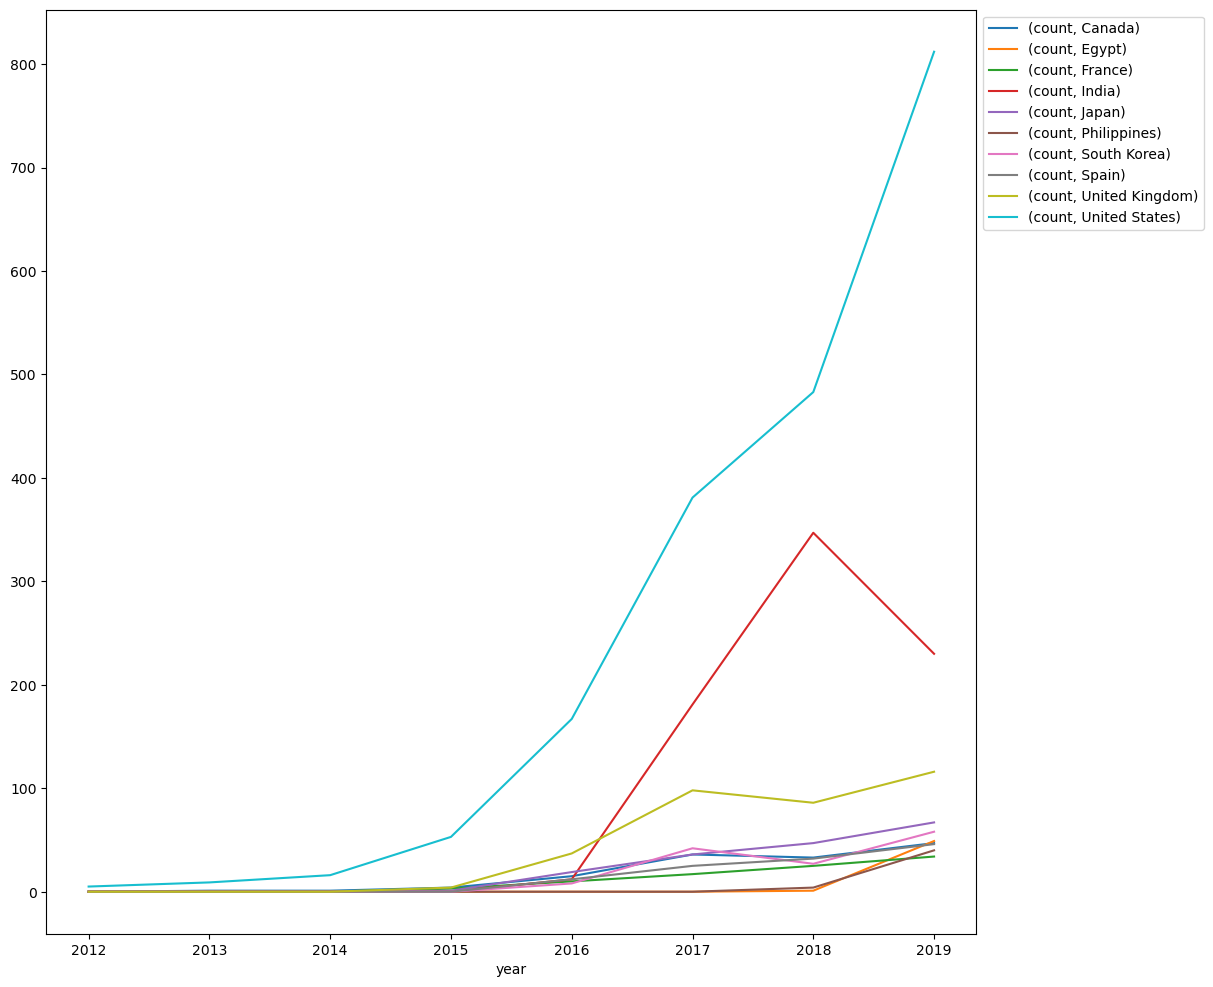

In [110]:
temp= result.loc[result['country'].isin(filter)]
temp=temp.set_index(['year', 'country'])
temp=temp.unstack(level=-1)
temp.fillna(0,inplace=True)
temp.plot(figsize=(12, 12)).legend(bbox_to_anchor=(1, 1))
plt.show()